In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

from nltk.stem import PorterStemmer
from nltk import word_tokenize,sent_tokenize

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [3]:
train = pd.read_csv('./file/data/train.tsv',sep='\t',names = ["Sentence", "Class", "Delete"])
test = pd.read_csv('./file/data/test.tsv',sep='\t',names = ["Sentence", "Class", "Delete"])
val_data = pd.read_csv("./file/data/dev.tsv", sep="\t", header=None, names=["Sentence", "Class", "Delete"])

In [4]:
train = train.drop("Delete", axis=1)
test = test.drop("Delete", axis=1)
val_data = val_data.drop("Delete", axis=1)

In [5]:
train.head()

,Sentence,Class
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [6]:
test.head()

,Sentence,Class
0,I’m really sorry about your situation :( Altho...,25
1,It's wonderful because it's awful. At not with.,0
2,"Kings fan here, good luck to you guys! Will be...",13
3,"I didn't know that, thank you for teaching me ...",15
4,They got bored from haunting earth for thousan...,27


In [7]:
val_data.head()

,Sentence,Class
0,Is this in New Orleans?? I really feel like th...,27
1,"You know the answer man, you are programmed to...","4,27"
2,I've never been this sad in my life!,25
3,The economy is heavily controlled and subsidiz...,"4,27"
4,He could have easily taken a real camera from ...,20


In [8]:
print(train.shape)
print(test.shape)
print(val_data.shape)


(43410, 2)
(5427, 2)
(5426, 2)


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  43410 non-null  object
 1   Class     43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


# Data Preprocessing

In [11]:
train["Class list"] = train["Class"].apply(lambda x: x.split(","))
train["Class len"] = train["Class list"].apply(lambda x: len(x))

test["Class list"] = test["Class"].apply(lambda x: x.split(","))
test["Class len"] = test["Class list"].apply(lambda x: len(x))

val_data["Class list"] = val_data["Class"].apply(lambda x: x.split(","))
val_data["Class len"] = val_data["Class list"].apply(lambda x: len(x))

In [12]:
train.head()

,Sentence,Class,Class list,Class len
0,My favourite food is anything I didn't have to...,27,[27],1
1,"Now if he does off himself, everyone will thin...",27,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1
3,To make her feel threatened,14,[14],1
4,Dirty Southern Wankers,3,[3],1


In [13]:
val_data.head()

,Sentence,Class,Class list,Class len
0,Is this in New Orleans?? I really feel like th...,27,[27],1
1,"You know the answer man, you are programmed to...","4,27","[4, 27]",2
2,I've never been this sad in my life!,25,[25],1
3,The economy is heavily controlled and subsidiz...,"4,27","[4, 27]",2
4,He could have easily taken a real camera from ...,20,[20],1


In [14]:
with open("./file/data/ekman_mapping.json") as file:
    ekman_mapping = json.load(file)

In [15]:
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}

In [16]:
emotion_file = open("./file/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)
print(len(emotion_list))

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
28


In [17]:
def idx2class(idxlist):
    arr = []
    for i in idxlist:
        arr.append(emotion_list[int(i)])
    return arr

In [18]:
train["Emotion"] = train["Class list"].apply(idx2class)
test["Emotion"] = test["Class list"].apply(idx2class)
val_data["Emotion"] = val_data["Class list"].apply(idx2class)

In [19]:
train.head()

,Sentence,Class,Class list,Class len,Emotion
0,My favourite food is anything I didn't have to...,27,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1,[anger]
3,To make her feel threatened,14,[14],1,[fear]
4,Dirty Southern Wankers,3,[3],1,[annoyance]


In [20]:
val_data.head()

,Sentence,Class,Class list,Class len,Emotion
0,Is this in New Orleans?? I really feel like th...,27,[27],1,[neutral]
1,"You know the answer man, you are programmed to...","4,27","[4, 27]",2,"[approval, neutral]"
2,I've never been this sad in my life!,25,[25],1,[sadness]
3,The economy is heavily controlled and subsidiz...,"4,27","[4, 27]",2,"[approval, neutral]"
4,He could have easily taken a real camera from ...,20,[20],1,[optimism]


In [21]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping["anger"]:
            map_list.append("anger")
        if i in ekman_mapping["disgust"]:
            map_list.append("disgust")
        if i in ekman_mapping["fear"]:
            map_list.append("fear")
        if i in ekman_mapping["joy"]:
            map_list.append("joy")
        if i in ekman_mapping["sadness"]:
            map_list.append("sadness")
        if i in ekman_mapping["surprise"]:
            map_list.append("surprise")
        if i == "neutral":
            map_list.append("neutral")
            
    return map_list

In [22]:
train["Mapped_emotion"] = train["Emotion"].apply(EmotionMapping)
test["Mapped_emotion"] = test["Emotion"].apply(EmotionMapping)
val_data["Mapped_emotion"] = val_data["Emotion"].apply(EmotionMapping)

In [23]:
train.head()

,Sentence,Class,Class list,Class len,Emotion,Mapped_emotion
0,My favourite food is anything I didn't have to...,27,[27],1,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",27,[27],1,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1,[anger],[anger]
3,To make her feel threatened,14,[14],1,[fear],[fear]
4,Dirty Southern Wankers,3,[3],1,[annoyance],[anger]


In [24]:
val_data.head()

,Sentence,Class,Class list,Class len,Emotion,Mapped_emotion
0,Is this in New Orleans?? I really feel like th...,27,[27],1,[neutral],[neutral]
1,"You know the answer man, you are programmed to...","4,27","[4, 27]",2,"[approval, neutral]","[joy, neutral]"
2,I've never been this sad in my life!,25,[25],1,[sadness],[sadness]
3,The economy is heavily controlled and subsidiz...,"4,27","[4, 27]",2,"[approval, neutral]","[joy, neutral]"
4,He could have easily taken a real camera from ...,20,[20],1,[optimism],[joy]


In [25]:
train_data_1= train["Mapped_emotion"].str.split(",", expand=True)
test_data_1= test["Mapped_emotion"].str.split(",", expand=True)
val_data_1= val_data["Mapped_emotion"].str.split(",", expand=True)

In [26]:
val_data.head()

,Sentence,Class,Class list,Class len,Emotion,Mapped_emotion
0,Is this in New Orleans?? I really feel like th...,27,[27],1,[neutral],[neutral]
1,"You know the answer man, you are programmed to...","4,27","[4, 27]",2,"[approval, neutral]","[joy, neutral]"
2,I've never been this sad in my life!,25,[25],1,[sadness],[sadness]
3,The economy is heavily controlled and subsidiz...,"4,27","[4, 27]",2,"[approval, neutral]","[joy, neutral]"
4,He could have easily taken a real camera from ...,20,[20],1,[optimism],[joy]


In [27]:
train_data_1 = pd.DataFrame(train["Mapped_emotion"].tolist())
test_data_1 = pd.DataFrame(test["Mapped_emotion"].tolist())
val_data_1 = pd.DataFrame(val_data["Mapped_emotion"].tolist())


train_data_1.reset_index(drop=True, inplace=True)
test_data_1.reset_index(drop=True, inplace=True)
val_data_1.reset_index(drop=True, inplace=True)

In [28]:
val_data_1.head()

,0,1,2,3
0,neutral,None,None,None
1,joy,neutral,None,None
2,sadness,None,None,None
3,joy,neutral,None,None
4,joy,None,None,None


In [29]:
train_data_1.drop(train_data_1.columns[1:5], axis=1, inplace=True)
test_data_1.drop(test_data_1.columns[1:5], axis=1, inplace=True)
val_data_1.drop(val_data_1.columns[1:5], axis=1, inplace=True)

In [30]:
val_data_1.head()

,0
0,neutral
1,joy
2,sadness
3,joy
4,joy


In [31]:
train_data = pd.concat([train, train_data_1], axis=1)
test_data = pd.concat([test, test_data_1], axis=1)
val_data = pd.concat([val_data, val_data_1], axis=1)

In [32]:
val_data.head()

,Sentence,Class,Class list,Class len,Emotion,Mapped_emotion,0
0,Is this in New Orleans?? I really feel like th...,27,[27],1,[neutral],[neutral],neutral
1,"You know the answer man, you are programmed to...","4,27","[4, 27]",2,"[approval, neutral]","[joy, neutral]",joy
2,I've never been this sad in my life!,25,[25],1,[sadness],[sadness],sadness
3,The economy is heavily controlled and subsidiz...,"4,27","[4, 27]",2,"[approval, neutral]","[joy, neutral]",joy
4,He could have easily taken a real camera from ...,20,[20],1,[optimism],[joy],joy


In [33]:
train_data = train_data.drop(["Class", "Class list", "Class len", "Emotion","Mapped_emotion"], axis=1)
test_data = test_data.drop(["Class", "Class list", "Class len", "Emotion","Mapped_emotion"], axis=1)
val_data = val_data.drop(["Class", "Class list", "Class len", "Emotion","Mapped_emotion"], axis=1)

In [34]:
val_data.head()

,Sentence,0
0,Is this in New Orleans?? I really feel like th...,neutral
1,"You know the answer man, you are programmed to...",joy
2,I've never been this sad in my life!,sadness
3,The economy is heavily controlled and subsidiz...,joy
4,He could have easily taken a real camera from ...,joy


In [35]:
train_data.rename(columns={0: "Emotion"}, inplace=True)
test_data.rename(columns={0: "Emotion"}, inplace=True)
val_data.rename(columns={0: "Emotion"}, inplace=True)

In [36]:
train_data.Emotion.value_counts()

Emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

# WORD CLOUD

In [38]:
emotion_list = train_data["Emotion"].unique()
emotion_list

array(['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness',
       'disgust'], dtype=object)

In [39]:
def word_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.suptitle(df + " Word Cloud", size=15)
    plt.imshow(wordcloud)
    plt.axis("off")

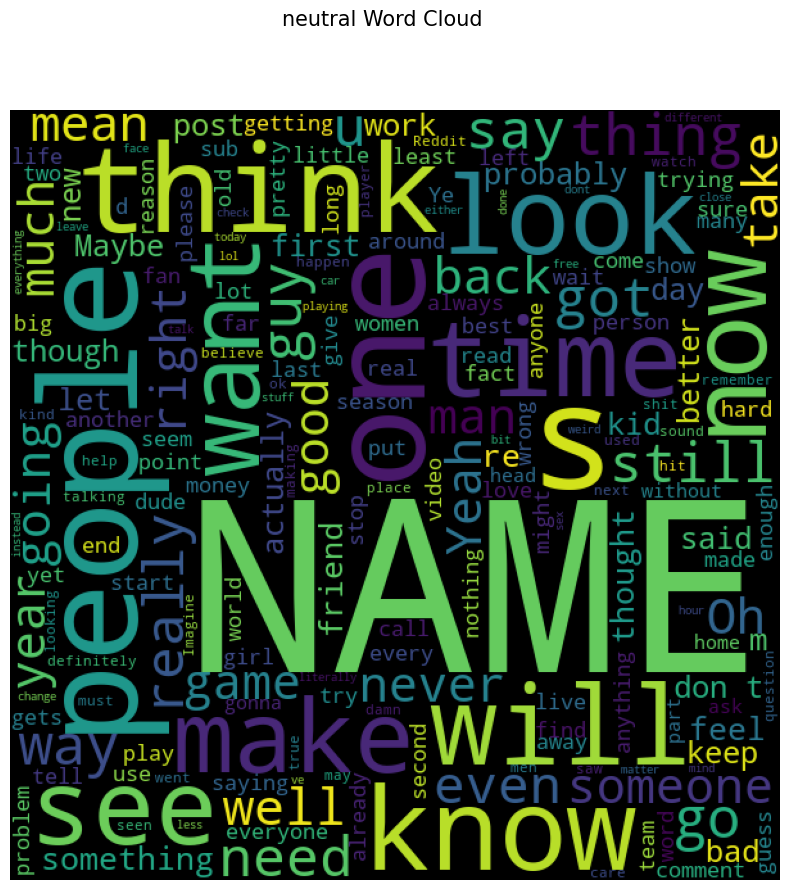

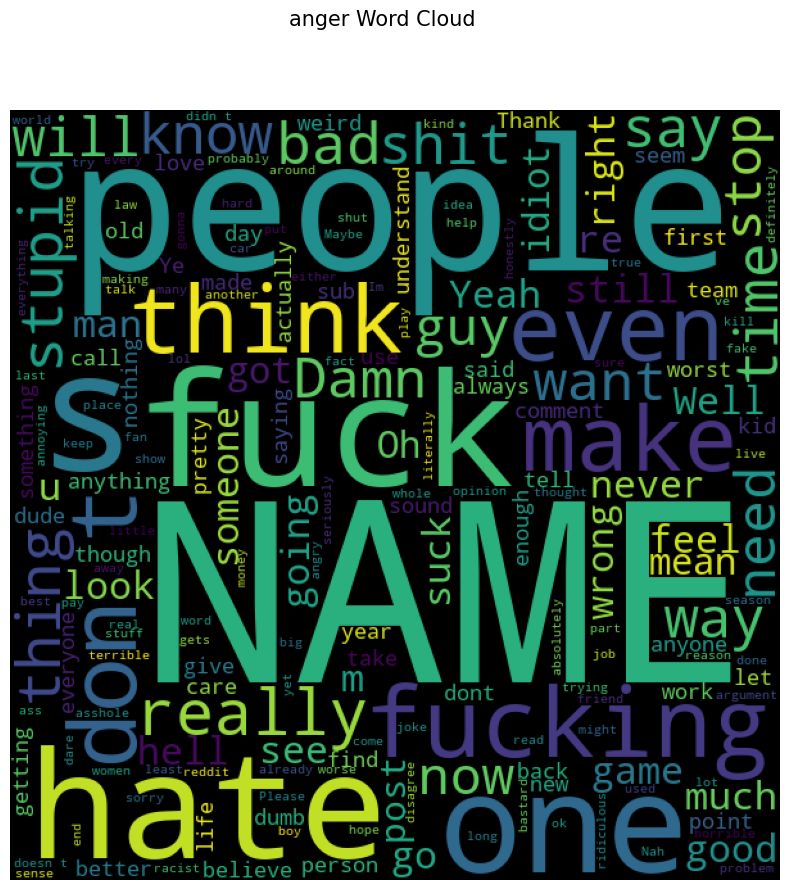

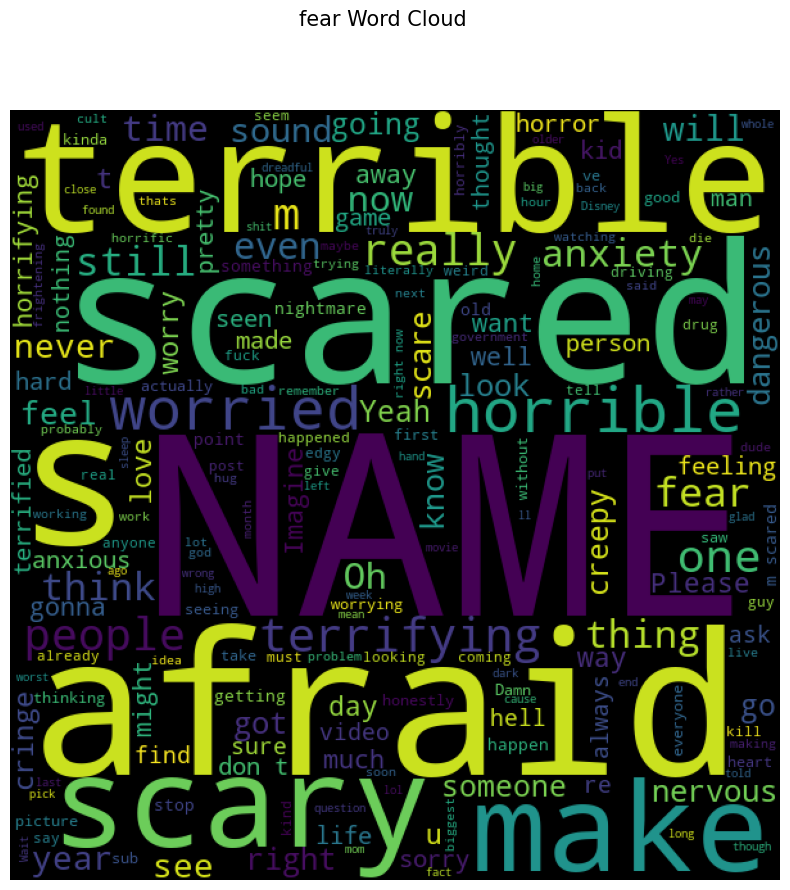

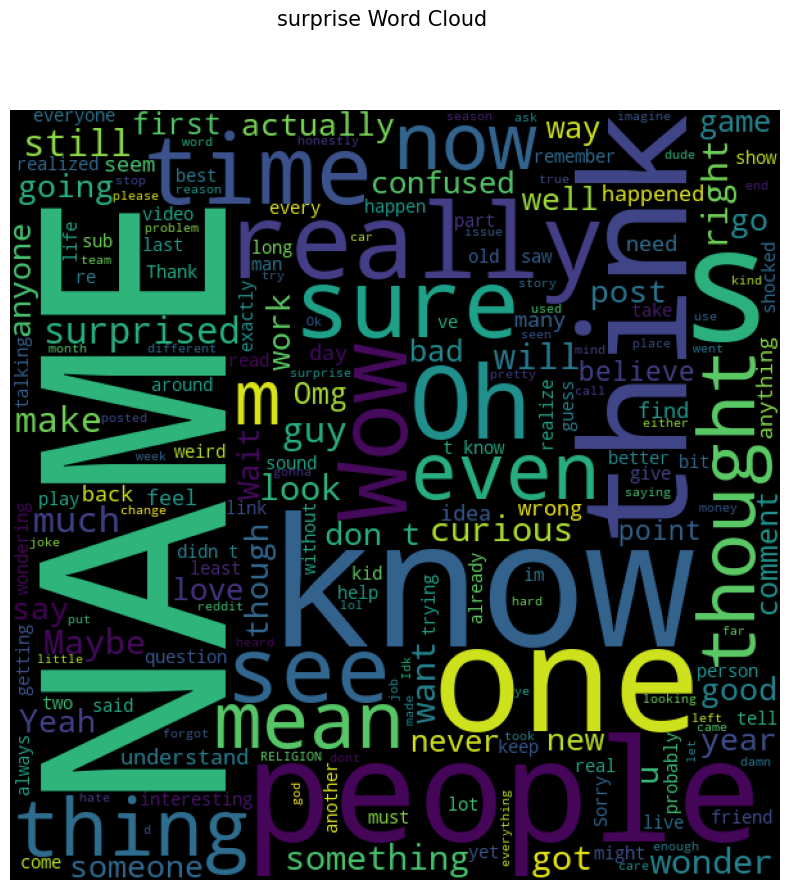

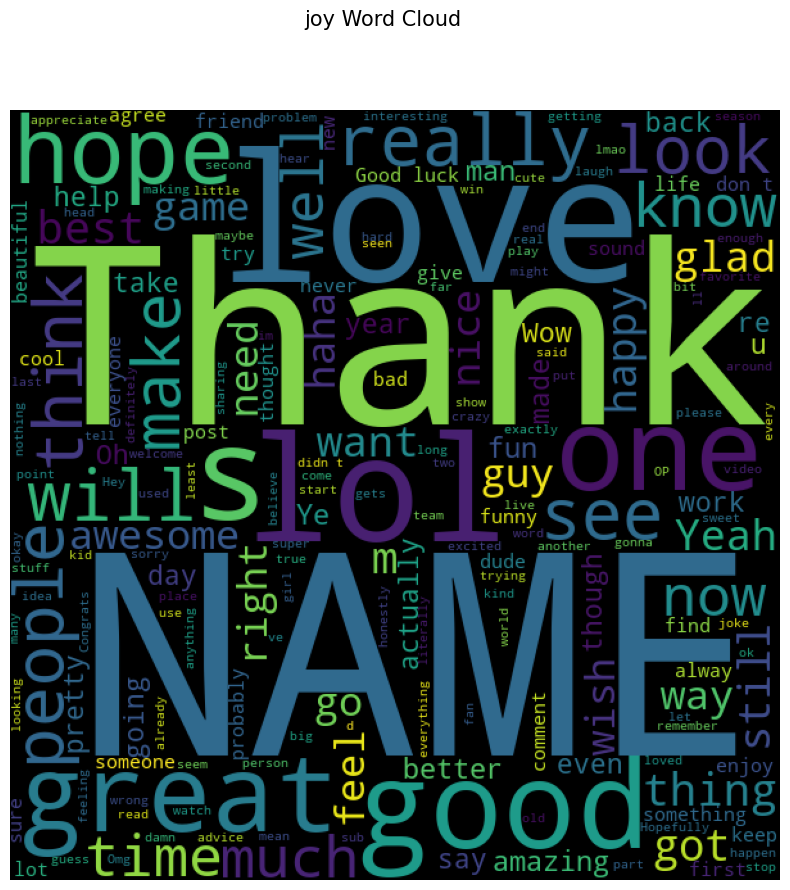

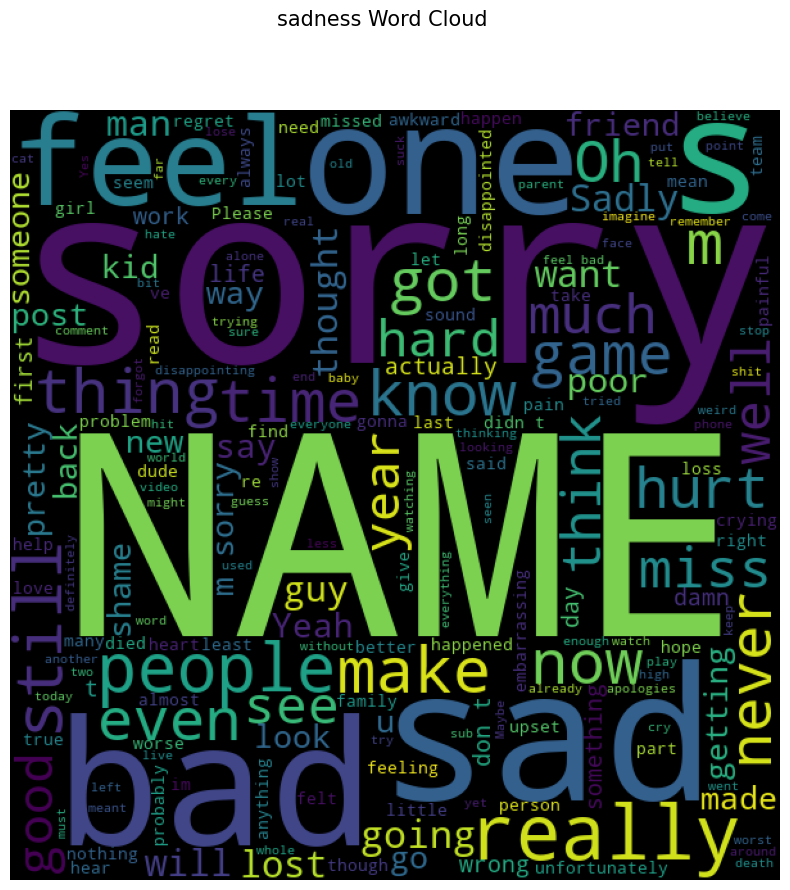

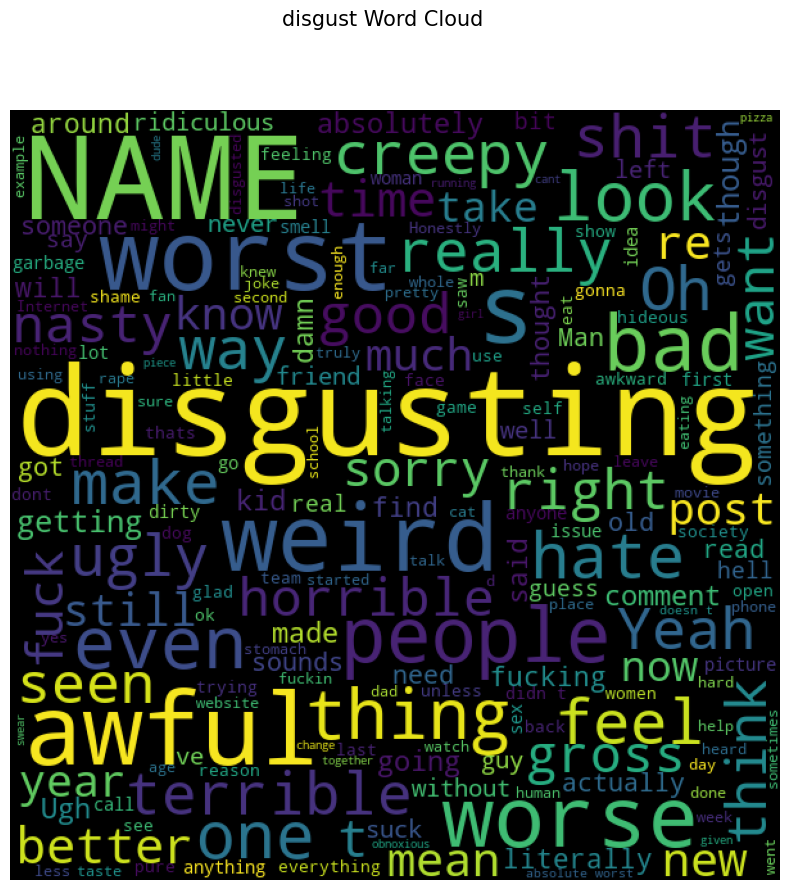

In [40]:
for emotion in emotion_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data["Emotion"] == emotion, "Sentence"]])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    word_cloud(wordcloud, emotion)

In [41]:
train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
val_data["Emotion"] = val_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})

C:\Users\ssttg\AppData\Local\Temp\ipykernel_19484\3481180256.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data["Emotion"] = train_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
C:\Users\ssttg\AppData\Local\Temp\ipykernel_19484\3481180256.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data["Emotion"] = test_data.Emotion.replace({"anger":0, "disgust":1, "fear":2, "joy":3, "sadness":4, "surprise":5, "neutral":6})
C:\Users\ssttg\AppData\Local\Temp\ipyker

In [42]:
train_data.head()

,Sentence,Emotion
0,My favourite food is anything I didn't have to...,6
1,"Now if he does off himself, everyone will thin...",6
2,WHY THE FUCK IS BAYLESS ISOING,0
3,To make her feel threatened,2
4,Dirty Southern Wankers,0


In [43]:
# Check for null values
print("Train data:\n", train_data.isnull().sum())
print("Test data: \n", test_data.isnull().sum())
print("Validation data: \n", val_data.isnull().sum())

# Check duplicated values
print("\n \n Train data:", train_data.duplicated().sum())
print("Test data:", test_data.duplicated().sum())
print("Validation data:", val_data.duplicated().sum())

Train data:
 Sentence    0
Emotion     0
dtype: int64
Test data: 
 Sentence    0
Emotion     0
dtype: int64
Validation data: 
 Sentence    0
Emotion     0
dtype: int64

 
 Train data: 152
Test data: 6
Validation data: 3


In [44]:
#Removing Duplicated values
index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis=0, inplace=True)
train_data.reset_index(inplace=True, drop=True)

index = test_data[test_data.duplicated() == True].index
test_data.drop(index, axis=0, inplace=True)
test_data.reset_index(inplace=True, drop=True)

index = val_data[val_data.duplicated() == True].index
val_data.drop(index, axis=0, inplace=True)
val_data.reset_index(inplace=True, drop=True)

In [45]:
# Check for null values
print("Train data:\n", train_data.isnull().sum())
print("Test data: \n", test_data.isnull().sum())
print("Validation data: \n", val_data.isnull().sum())

# Check duplicated values
print("\n \n Train data:", train_data.duplicated().sum())
print("Test data:", test_data.duplicated().sum())
print("Validation data:", val_data.duplicated().sum())

Train data:
 Sentence    0
Emotion     0
dtype: int64
Test data: 
 Sentence    0
Emotion     0
dtype: int64
Validation data: 
 Sentence    0
Emotion     0
dtype: int64

 
 Train data: 0
Test data: 0
Validation data: 0


In [46]:
train_data[train_data["Sentence"].duplicated() == True]

,Sentence,Emotion
6610,My man!,3
7925,What do you mean?,5
8344,Weird flex but okay,3
8978,[NAME],6
9375,Grow up.,0
9481,Weird flex but ok,1
14012,You're welcome,6
14104,This is horrible,2
15809,Lol no.,3
20768,Oh boy yeah,3


In [47]:
test_data[test_data["Sentence"].duplicated() == True]

,Sentence,Emotion


In [48]:
val_data[val_data["Sentence"].duplicated() == True]

,Sentence,Emotion


In [49]:
index = train_data[train_data["Sentence"].duplicated() == True].index
train_data.drop(index, axis=0, inplace = True)
train_data.reset_index(inplace=True, drop=True)

In [50]:
val_data = val_data.drop([22, 23])

In [51]:
val_data.head()

,Sentence,Emotion
0,Is this in New Orleans?? I really feel like th...,6
1,"You know the answer man, you are programmed to...",3
2,I've never been this sad in my life!,4
3,The economy is heavily controlled and subsidiz...,3
4,He could have easily taken a real camera from ...,3


# Data Visualizing and Analysis

In [53]:
X = train_data["Sentence"]

In [54]:
lst = []
for i in X:
    lst.append(len(i))
    
len1 = pd.DataFrame(lst)
len1.describe()

,0
count,43227.000000
mean,68.630694
std,36.625139
min,2.000000
25%,38.000000
50%,65.000000
75%,96.000000
max,703.000000


In [55]:
cts = []
for i in range(7, 301):
    ct=0
    for k in lst:
        if k==i:
            ct+=1
    cts.append(ct)

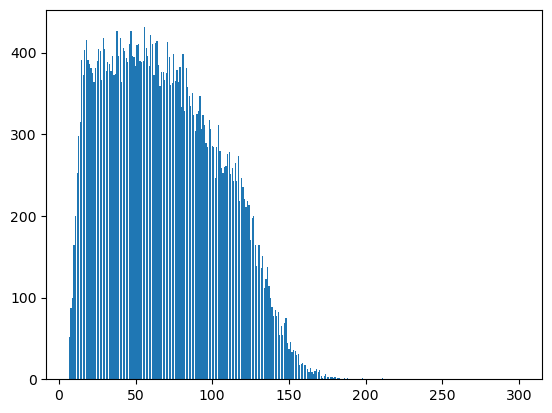

In [56]:
plt.bar(range(7, 301), cts)
plt.show()

<Axes: xlabel='Emotion', ylabel='count'>

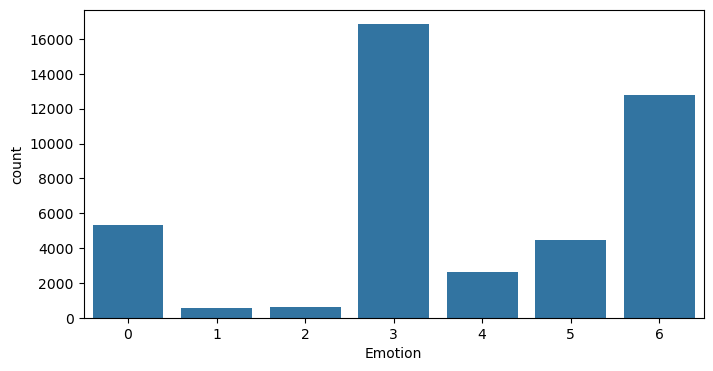

In [57]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=train_data)

<Axes: xlabel='Emotion', ylabel='count'>

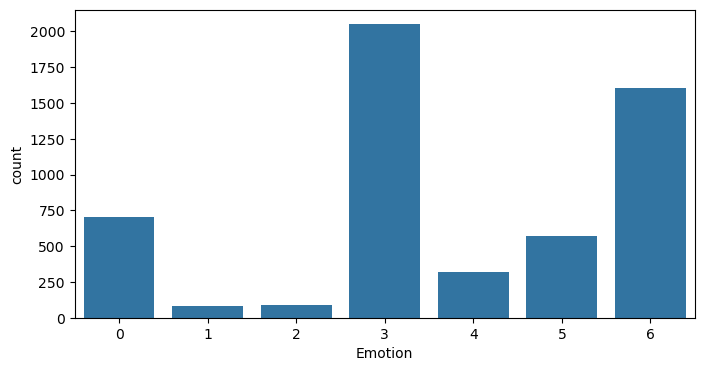

In [58]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=test_data)

<Axes: xlabel='Emotion', ylabel='count'>

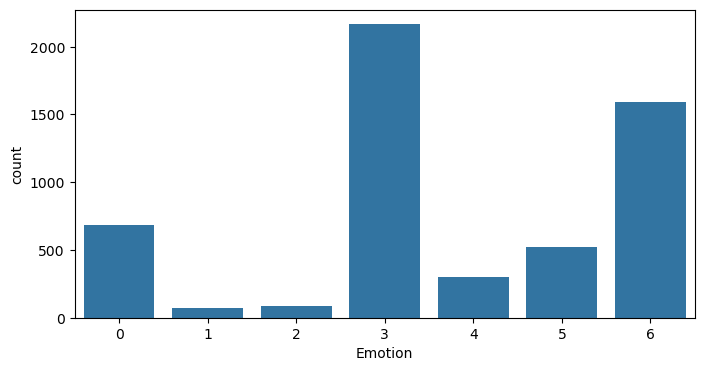

In [59]:
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=val_data)

# Data Cleaning

In [61]:
train_data["Length"] = [len(x) for x in train_data["Sentence"]]

In [62]:
print(len(stopwords))

# Max length of senetence
max_len = train_data["Length"].max()
print(max_len)

179
703


In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)

In [64]:
vocabsize = 18000   #20-12551 #30-15000 43-17555
vocabsize = int(vocabsize * 5 )
print(vocabsize)


90000


In [65]:
def text_cleaning(df, column):
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    # Split each sentence into a list of words and flatten the list of lists into a single list
    words = [word.lower() for sentence in corpus for word in nltk.word_tokenize(sentence)]

    # Convert the list of words into a set to remove duplicates and find the number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)

    print(f"Number of unique words: {num_unique_words}")
    one_hot_word = [one_hot(input_text=word, n=vocabsize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    print(pad.shape)
    return pad

In [66]:
X_train = text_cleaning(train_data, "Sentence")
X_test = text_cleaning(test_data, "Sentence")
X_val = text_cleaning(val_data, "Sentence")

Number of unique words: 17555
(43227, 703)
Number of unique words: 6167
(5421, 703)
Number of unique words: 6237
(5421, 703)


In [67]:
X_train

array([[    0,     0,     0, ..., 58287, 64736, 56493],
       [    0,     0,     0, ..., 77414, 32379, 82117],
       [    0,     0,     0, ..., 13548, 54312, 47145],
       ...,
       [    0,     0,     0, ..., 54318, 68058, 23013],
       [    0,     0,     0, ..., 40392, 45253,  2878],
       [    0,     0,     0, ...,     0, 57134, 31292]])

In [68]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = val_data["Emotion"]

In [69]:
y_train

0        6
1        6
2        0
3        2
4        0
        ..
43222    3
43223    5
43224    0
43225    3
43226    3
Name: Emotion, Length: 43227, dtype: int64

In [70]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

In [72]:
smote = SMOTE(sampling_strategy='minority')
X_test, y_test = smote.fit_resample(X_test, y_test)
y_test.shape

(7386, 7)

In [73]:
smote = SMOTE(sampling_strategy='minority')
X_val, y_val = smote.fit_resample(X_val, y_val)

# Model

In [75]:
# Model creation
model = Sequential()
model.add(Embedding(input_dim=vocabsize, output_dim=300, input_length=max_len)) 
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(60, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.build(input_shape=(None, max_len))  
model.summary()


C:\Users\ssttg\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 703, 300)            │      27,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 703, 300)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 703, 512)            │       1,665,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 60)                  │          15,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             427 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,468,327 (112.41 MB)

 Trainable params: 29,468,327 (112.41 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [77]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [ ]:
hist = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/12
  33/1859 ━━━━━━━━━━━━━━━━━━━━ 3:27:18 7s/step - accuracy: 0.2495 - loss: 1.8065